In [294]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from tqdm import tqdm

from collections import defaultdict
import itertools
import random
import re
import time

In [295]:
## You are always welcome to implement your own function without using external libraries.

## Implement Weighted Jaccard similarity

In [296]:
## read M.txt and store col, row, val in a list of dictionaries

items = defaultdict(list)

with open(f"M.txt", "r") as f:
    for line in f:
        _line = list(map(int, line.rstrip().split(",")))
        items[_line[0]].append(tuple([_line[1], _line[-1]]))

In [297]:
item_vec = [[0] * 5 for i in range(3)]

for i in range(3):
    for user in items[i]:
        item_vec[i][user[0]] = user[1]

In [298]:
## Task 1. Implement the weighted_jaccard_similarity.

def weighted_jaccard_similarity(s1, s2):
    ans = 0
    #### Implement here ####
    
    sum_of_intersection = 0
    sum_of_union = 0
    for x_i, y_i in zip(s1, s2):
        sum_of_intersection += min(x_i, y_i)
        sum_of_union += max(x_i, y_i)
    
    ans = sum_of_intersection / sum_of_union
   
    ########################
        
    return ans

In [300]:
print(weighted_jaccard_similarity(item_vec[0], item_vec[1]))
print(weighted_jaccard_similarity(item_vec[1], item_vec[2]))
print(weighted_jaccard_similarity(item_vec[0], item_vec[2]))

0.6363636363636364
0.1875
0.35714285714285715


## Implement a code that returns shingle per items

In [301]:
## Task 2. Implement build_items_to_shingle_dictionary.

In [302]:
# Sub-function that will be used in the next tasks.
# Please implement this function for future use.

def get_shingles(items):
    shingles = []
    
    #### Implement here ####
    
    users = set()
    ratings = set()
    for item in items.values():
        for feedback in item:
            users.add(feedback[0])
            ratings.add(feedback[1])
    
    shingles = list(itertools.product(users, ratings))
    
    ########################
    
    return set(shingles)

In [303]:
def build_items_to_shingle_dictionary(items, shingles):
    item_to_shingles = {}
    
    #### Implement here ####
    
    shingle_to_idx = {}
    for i, shingle in enumerate(sorted(shingles)):
        shingle_to_idx[shingle] = i
    
    
    for item_no, item in items.items():
        buf = []
        for feedback in item:
            user_no, rate = feedback
            for i in range(1, rate+1):
                buf.append((user_no, i))
                
        item_to_shingles[item_no] = [shingle_to_idx[i] for i in buf]
    
    ########################
    
    
    return item_to_shingles

In [304]:
shingles = get_shingles(items)
item_to_shingles = build_items_to_shingle_dictionary(items, shingles)

In [308]:
len(shingles)

25

In [309]:
item_to_shingles

{0: [0, 1, 2, 10, 15, 16, 17, 18, 19],
 1: [0, 1, 5, 15, 16, 17, 18, 19, 20],
 2: [0, 1, 2, 3, 4, 10, 11, 12, 13, 15]}

In [310]:
# Task 3. Implement jaccard_similarity.
def jaccard_similarity(s1, s2):
    ans = 0
    #### Implement here ####
    
    ans = len(s1.intersection(s2)) / len(s1.union(s2))
    
    
    ########################
        
    return ans

In [311]:
print(jaccard_similarity(set(item_to_shingles[0]), set(item_to_shingles[1])))
print(jaccard_similarity(set(item_to_shingles[1]), set(item_to_shingles[2])))
print(jaccard_similarity(set(item_to_shingles[0]), set(item_to_shingles[2])))

0.6363636363636364
0.1875
0.35714285714285715


## Import MovieLens dataset

In [312]:
mov2usr_rate = defaultdict(list)


with open(f"Rating.txt", "r") as f:
    for line in f:
        _line = list(map(int, line.rstrip().split(",")))
        mov2usr_rate[_line[1]].append(tuple([_line[0], _line[-1]]))

In [313]:
index2movie = defaultdict(str)

with open(f"MovieInfo.txt", "r") as f:
    for line in f:
        _line = line.rstrip().split(",")
        index2movie[int(_line[0])] = _line[-1]

In [314]:
# Check whether your implementation is correct
if len(mov2usr_rate) == 10677:
    print('Test passed')

Test passed


#### 1.1 Get Shingles from the movies (Hint: Reuse the code you implemented in Task 2!)

In [315]:
def get_shingles(items):
    shingles = []
    
    #### Implement here ####
    
    users = defaultdict(int)
    for item in items.values():
        for feedback in item:
            user_no, rate = feedback
            
            users[user_no] = max(users[user_no], rate)
    
    for user_no, max_rate in users.items():
        for i in range(1, max_rate+1):
                shingles.append((user_no, i))
    
    
    ########################
    
    return set(shingles)

In [316]:
start = time.time()
shingles = get_shingles(mov2usr_rate)
end = time.time()
print(end - start)

4.779030084609985


In [317]:
# Check whether your implementation is correct
if len(shingles) == 348290:
    print('Test passed')

Test passed


#### 1.2 Build dictionary

In [318]:
item_to_shingles = build_items_to_shingle_dictionary(mov2usr_rate, shingles)

In [319]:
# Check whether your implementation is correct
if len(item_to_shingles) == 10677 and len(item_to_shingles[0]) == 6997:
    print('Test passed')

Test passed


### 2. Min-Hashing

#### 2.1 Generate Prime numbers for Universal Hashing

In [320]:
def is_prime(n):
    for i in range(2,int(np.sqrt(n))+1):
        if not n % i:
            return False
    return True

def generate_prime_numbers(M, N):
    primes = []
    cnt = 0
    n = N + 1
    
    while cnt < M:
        if is_prime(n):
            primes.append(n)
            cnt += 1
        n += 1
    return primes

#### 2.2 Min Hash

In [321]:
M = 100
N = len(shingles)

class Hash():
    def __init__(self, M, N, primes):
        self.M = M
        self.N = N
        self.primes = primes
        
        self.a = np.random.choice(np.arange(999,9999), M, replace = False)
        self.b = np.random.choice(np.arange(self.N), M, replace = False)
    
    def __call__(self, x):
        return np.mod(np.mod((self.a * x + self.b), self.primes), self.N)
    

def min_hash(item_to_shingles, M, N):
    C = len(item_to_shingles)

    signatures = np.array(np.ones((M, C)) * np.inf, dtype = np.int)
    primes = generate_prime_numbers(M, N)
    hash_func = Hash(M, N, primes)
    
    for item_idx, shingle_idxes in tqdm(item_to_shingles.items()):
        hash_arr = np.array([hash_func(shingle_idx) for shingle_idx in shingle_idxes])
        
        sig = np.min(hash_arr, 0)
        signatures[np.arange(M), item_idx] = sig

    return signatures

### 3. Locality Sensitive Hashing

#### 3.1 Min-Hash based LSH

In [322]:
def lsh(signatures, b, r):
    """
        b bands
        r rows per band
        
        각 band는 k개의 버킷을 가지고 있고, 밴드별로 할당된 signarue의 열(r 길이)을 k개의 버킷에 해싱한다.
        해싱을 할때 하나의 밴드라도 동일한 버킷에 들어간다면 두 컬럼은 비슷하다고 본다.
        
        여기서 b가 커지면 similarity threshold가 낮다. (higher false positive)
        
        즉, b가 커지면 r이 작아져서 문서들이 비슷하다고 판단될 확률이 높아진다고 볼 수 있음.
        
    """
    candidatePairs = set()
    
    M = signatures.shape[0]  # The number of min-hash functions
    C = signatures.shape[1]  # The number of movies
    
    assert M == b * r
    
    #### Implement here ####
    
    # band 수로 나누기
    for band in np.split(signatures, b): 
        
        # band 별로 bucket 초기화
        bucket = defaultdict(list)
        
        # bucket에 매칭이 됨.
#         print(len(band.T))
        for idx, item in enumerate(band.T):
            key = tuple(item) # hash를 조금 생각 해봐야할지도..
            bucket[key].append(idx)
        
#         print(len(bucket.keys()))
        # add to candidatePairs
        for _,matched in bucket.items():
            
            for pair in itertools.combinations(matched, 2):
                candidatePairs.add(pair)
        
    ########################
    

    return candidatePairs

#### 3.2 Compute the precision, recall, and F1 score

In [323]:
# Compute the number of positives
signatures = min_hash(item_to_shingles, M, N)
s = 0.4  # threshold
numConditionPositives = 1319 # This is the computed result when s=0.4, but I gave it to you to save your time.

computeConditionPositives = True # If you want to calculate it, then change it to True. It will take 30 minutes to compute.


if computeConditionPositives:
    positivePairs = set()
    testShingle = defaultdict(set)
    numConditionPositives = 0
    compareDist = defaultdict(list)
    idx2size = defaultdict(int)

    for key in index2movie.keys():
        testShingle[key] = set(item_to_shingles[key])
        
    numItems = len(mov2usr_rate.keys())

    for i in range(numItems):
        shingle1 = testShingle[i]
        size1 = len(shingle1)
        idx2size[i] = size1
        for j in range(i+1, numItems):
            shingle2 = testShingle[j]
            size2 = len(shingle2)
            idx2size[j] = size2
            if size2 <= size1:
                compareDist[i].append(j)
            else:
                compareDist[j].append(i)
    
    for i in tqdm(range(numItems)):
        shingle1 = testShingle[i]
        size1 = idx2size[i]

        for j in compareDist[i]:
            size2 = idx2size[j]
            if 2 * size1 > 5 * size2:
                continue
            shingle2 = testShingle[j]
            true_sim = jaccard_similarity(shingle1, shingle2)
            if true_sim >= s:
                numConditionPositives += 1
                
                # add positive pairs (i, j), 추가 포인트
                positivePairs.add((i, j))
                

print(f"The number of condition positives: {numConditionPositives} when s={s}")

/tmp/ipykernel_1516/1366249128.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  signatures = np.array(np.ones((M, C)) * np.inf, dtype = np.int)
100%|█████████████████████████████████████████████████████████████████████████████| 10677/10677 [16:10<00:00, 11.01it/s]

The number of condition positives: 1319 when s=0.4


In [324]:
# Return query_time, precision, recall, F1 score
def query_analysis(signatures, b, s, numConditionPositives):
    
    #### Implement here ####
    
    start = time.time()
    candidatePairs = lsh(signatures, b, r=len(signatures)//b)
    query_time = time.time() - start
    
    
    recall = len(positivePairs.intersection(candidatePairs))/len(positivePairs)
    precision = len(positivePairs.intersection(candidatePairs)) /len(candidatePairs)
    
    f1 = 2 * (precision * recall) / (precision + recall)
    
    
    ########################
    

    return query_time, precision, recall, f1

In [325]:
# Return the list of every divisor of given integer
def find_divisors(x):
    divisors = list()
    for i in range(1, x):
        if x % i == 0:
            divisors.append(i)
    return divisors

In [332]:
b_list = find_divisors(M)

query_time_list = list()
precision_list = list()
recall_list = list()
f1_list = list()

for b in tqdm(b_list):
    query_time, precision, recall, f1 = query_analysis(signatures, b, s, numConditionPositives)
    query_time_list.append(query_time)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

100%|█████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:27<00:00,  3.43s/it]


In [333]:
print("b: ", b_list)
print("Query times: ", query_time_list)
print("Precisions: ", precision_list)
print("Recalls: ", recall_list)
print("F1 scores: ", f1_list)

b:  [1, 2, 4, 5, 10, 20, 25, 50]
Query times:  [0.0737009048461914, 0.0687246322631836, 3.3779137134552, 0.08999395370483398, 3.292668342590332, 3.331793785095215, 6.52165150642395, 10.516435623168945]
Precisions:  [0.9864864864864865, 0.7857142857142857, 0.6868131868131868, 0.6793478260869565, 0.6713615023474179, 0.20315398886827457, 0.06147826086956522, 0.000665225006764138]
Recalls:  [0.05534495830174375, 0.0667172100075815, 0.09476876421531463, 0.09476876421531463, 0.10841546626231995, 0.33206974981046244, 0.5360121304018196, 0.7437452615617892]
F1 scores:  [0.1048097631012204, 0.12299091544374564, 0.1665556295802798, 0.166333998669328, 0.18668407310704965, 0.25208633093525173, 0.11030501599188704, 0.0013292610880157832]


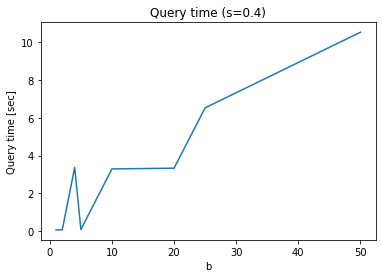

In [334]:
plt.title(f"Query time (s={s})")
plt.xlabel("b")
plt.ylabel("Query time [sec]")
plt.plot(b_list, query_time_list)
plt.show()

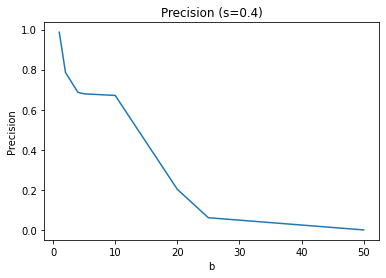

In [335]:
plt.title(f"Precision (s={s})")
plt.xlabel("b")
plt.ylabel("Precision")
plt.plot(b_list, precision_list)
plt.show()

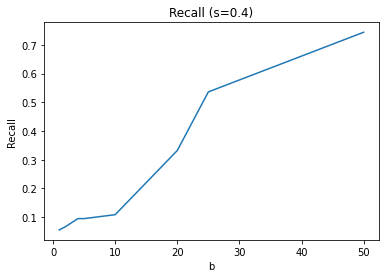

In [336]:
plt.title(f"Recall (s={s})")
plt.xlabel("b")
plt.ylabel("Recall")
plt.plot(b_list, recall_list)
plt.show()

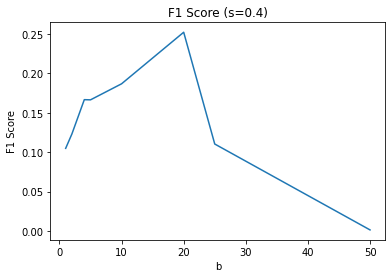

In [337]:
plt.title(f"F1 Score (s={s})")
plt.xlabel("b")
plt.ylabel("F1 Score")
plt.plot(b_list, f1_list)
plt.show()

### Case Study

In [338]:
# 37 Star Wars: Episode VI - Return of the Jedi (1983)
# 1459 Wallace & Gromit: A Grand Day Out (1989)
# 96 Toy Story (1995) , 0.37이 sim 최고치... 
# 1239 Harry Potter and the Goblet of Fire (2005)

In [341]:
#### Implement any functions here ####
    
# 내가 만든 lsh 함수랑 exact weighted Jaccard Similarity랑 비교 해라..

def generate_gt(query, item_to_shingles, s=0.4):
    """
        items : (N, shingles)
        return : {item_no : ranked list}
        
        **조교님 code를 가져와서 수정.** # query 별로 가져오면서 폐기
        
    """
    
    gt = defaultdict(list) # key : item_no, values : gt set

#     testShingle = defaultdict(set)
#     numConditionPositives = 0
#     compareDist = defaultdict(list)
#     idx2size = defaultdict(int)

#     for key in index2movie.keys():
#         testShingle[key] = set(item_to_shingles[key])

#     numItems = len(mov2usr_rate.keys())

#     for i in range(numItems):
#         shingle1 = testShingle[i]
#         size1 = len(shingle1)
#         idx2size[i] = size1
#         for j in range(i+1, numItems):
#             shingle2 = testShingle[j]
#             size2 = len(shingle2)
#             idx2size[j] = size2
#             if size2 <= size1:
#                 compareDist[i].append(j)
#             else:
#                 compareDist[j].append(i)

#     for i in tqdm(range(numItems)):
#         shingle1 = testShingle[i]
#         size1 = idx2size[i]

#         for j in compareDist[i]:
#             size2 = idx2size[j]
#             if 2 * size1 > 5 * size2:
#                 continue
#             shingle2 = testShingle[j]
#             true_sim = jaccard_similarity(shingle1, shingle2)
#             if true_sim >= s:
#                 numConditionPositives += 1

#                 # i, j pair를 gt 리스트에 추가
#                 gt[i].add(j)
#                 gt[j].add(i)
    
    
    numItems = len(item_to_shingles.keys())
    
    sorted_list = sorted([(i, jaccard_similarity(set(item_to_shingles[query]), set(item_to_shingles[i]))) for i in range(numItems) if i != query ]
    , key=lambda x : x[1], reverse=True)
    
    # s threshold 
    sorted_list = list(filter(lambda x : x[1] >= s, sorted_list))
    
    return sorted_list
    
    

def get_pred_list(query, candidatePairs):
    # lsh function을 이용해야하니, matched list를 만들고, 거기에 있는 값들을 다시 rerank?
    
    pred = []
    for pair in candidatePairs:
        if query == pair[0]:
            pred.append(pair[1])
        if query == pair[1]:
            pred.append(pair[0])    
    return pred

def rerank(query, pred, item_to_shingles):
    """
        rerank with weighted jaccard sim
        
    """
    # weight jaccard sim == jaccard sim with shingle
    ranked_list = sorted([(i, jaccard_similarity(set(item_to_shingles[query]), set(item_to_shingles[i]))) for i in pred], key=lambda x : x[1], reverse=True) # [0] item_no, [1] score
    
    return ranked_list

def precision(gt, pred):
    gt_set = set([e[1] for e in gt])
    pred_set = set([e[1] for e in pred])
    
    precision = len(gt_set.intersection(pred_set)) /len(pred_set)
    return precision


test_idx = [37, 1459, 96, 1239]
s = 0.3
b = 25
topN = 10

candidatePairs = lsh(signatures, b, r=len(signatures)//b)


for idx in tqdm(test_idx):
    gt = generate_gt(query=idx, item_to_shingles=item_to_shingles, s=s)
    
    pred = rerank(query=idx, pred=get_pred_list(idx, candidatePairs), item_to_shingles=item_to_shingles)[:topN]
    precN = precision(gt, pred)
    
    print("-----------------------------------------")
    print("-----------------------------------------")
#     print(len(gt), len(pred))#, pred)
    print("idx: ",idx, "title: ", index2movie[idx] ,": precision@%d :".format(topN), precN)
    print() # 개행
    
    # print ranked list
    print("similar item list")
    for i, (item_no, score) in enumerate(pred):
        print(str(i + 1) + " : " +  str(score) +", "+ index2movie[item_no])

    
######################################

 25%|█████████████████████▎                                                               | 1/4 [00:38<01:55, 38.49s/it]

-----------------------------------------
-----------------------------------------
idx:  37 title:  Star Wars: Episode VI - Return of the Jedi (1983) : precision@%d : 1.0

similar item list
1 : 0.5930796012403741, Star Wars: Episode V - The Empire Strikes Back (1980)
2 : 0.5865687451451169, Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977)
3 : 0.4483934754004366, Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
4 : 0.4245875644192358, Back to the Future (1985)
5 : 0.40740770976537627,  The (1984)
6 : 0.39834999689069767,  The (1999)
7 : 0.3722360108303249, Men in Black (1997)
8 : 0.3536450367165516, Aliens (1986)
9 : 0.35148015837815605, Alien (1979)
10 : 0.3494585374008557, Terminator 2: Judgment Day (1991)


 50%|██████████████████████████████████████████▌                                          | 2/4 [00:45<00:40, 20.26s/it]

-----------------------------------------
-----------------------------------------
idx:  1459 title:  Wallace & Gromit: A Grand Day Out (1989) : precision@%d : 0.3333333333333333

similar item list
1 : 0.4430215172593122, Wallace & Gromit: A Close Shave (1995)
2 : 0.14377402141870965,  A (1988)
3 : 0.08985641500694766,  The (1988)


 75%|███████████████████████████████████████████████████████████████▊                     | 3/4 [01:24<00:28, 28.39s/it]

-----------------------------------------
-----------------------------------------
idx:  96 title:  Toy Story (1995) : precision@%d : 0.9

similar item list
1 : 0.3739034164069363, Star Wars: Episode IV - A New Hope (a.k.a. Star Wars) (1977)
2 : 0.3454862907397827, Star Wars: Episode VI - Return of the Jedi (1983)
3 : 0.3267358304473893, Mission: Impossible (1996)
4 : 0.3195196095805445, Aladdin (1992)
5 : 0.31898654286386685, Forrest Gump (1994)
6 : 0.31500530709053504, Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
7 : 0.3131560733648633, Jurassic Park (1993)
8 : 0.3095433571996818, Fargo (1996)
9 : 0.30241065139845047, Groundhog Day (1993)
10 : 0.2981312631977248, Apollo 13 (1995)


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:30<00:00, 22.59s/it]

-----------------------------------------
-----------------------------------------
idx:  1239 title:  Harry Potter and the Goblet of Fire (2005) : precision@%d : 0.3

similar item list
1 : 0.45226533800616475, Harry Potter and the Prisoner of Azkaban (2004)
2 : 0.34902324916967253, Harry Potter and the Chamber of Secrets (2002)
3 : 0.30341815991567533, Pirates of the Caribbean: Dead Man's Chest (2006)
4 : 0.26438507261474353, Batman Begins (2005)
5 : 0.15067119701442655,  The (2004)
6 : 0.13406593406593406, Jarhead (2005)
7 : 0.10991012873451543, Mulan (1998)
8 : 0.09234468416948272, Cloverfield (2008)
9 : 0.08926624978486604,  The (2004)
10 : 0.08580984477124183, My Cousin Vinny (1992)


In [344]:
gt = generate_gt(query=37, item_to_shingles=item_to_shingles, s=s)
len(gt)

30

In [345]:
gt = generate_gt(query=1459 , item_to_shingles=item_to_shingles, s=s)
len(gt)

2

In [346]:
gt = generate_gt(query=96 , item_to_shingles=item_to_shingles, s=s)
len(gt)

15

In [347]:
gt = generate_gt(query=1239 , item_to_shingles=item_to_shingles, s=s)
len(gt)

6